In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import tsfresh
import os

# Load Dataset

In [2]:
import utils
dataset_folder = "dataset"
utils.datasets = utils.getDatasets(dataset_folder)
utils.showMapDataClass([1,2,3,4,5,6,7,8,9], ["no_speed_bump","speed_bump_asphalt", "speed_bump_cobblestone"], ["No Speed Bump","Speed Bump Asphalt", "Speed Bump Cobblestone"], [ "black","blue", "red" ])


In [3]:
utils.metricsDataClass(["speed_bump_asphalt", "speed_bump_cobblestone", "no_speed_bump"])

speed_bump_asphalt  speed_bump_cobblestone  no_speed_bump   Total  \
PVS                                                                      
1                   626                    2829         140581  144036   
2                  2006                       0         122679  124685   
3                   299                     310         105207  105816   
4                   530                    2604         129358  132492   
5                  1943                       0         131934  133877   
6                   281                     325          95673   96279   
7                   568                    2308         125672  128548   
8                  1837                       0         121781  123618   
9                   308                     335          90914   91557   

     speed_bump_asphalt_distribuition_%  \
PVS                                       
1                                  0.43   
2                                  1.61   
3                                  0.28   
4                                  0.40   
5                                  1.45   
6                                  0.29   
7                                  0.44   
8                                  1.49   
9                                  0.34   

     speed_bump_cobblestone_distribuition_%  no_speed_bump_distribuition_%  
PVS                                                                         
1                                      1.96                          97.60  
2                                      0.00                          98.39  
3                                      0.29                          99.42  
4                                      1.97                          97.63  
5                                      0.00                          98.55  
6                                      0.34                          99.37  
7                                      1.80                          97.76  
8                                      0.00                          98.51  
9                                      0.37                          99.30

# Preprocessing and Windowing

In [74]:
columns_to_drop = ['timestamp_gps','latitude','longitude']
df_l = pd.read_csv("dataset/PVS 1/dataset_gps_mpu_left.csv")
# drop columns
df_l = df_l.drop(columns=columns_to_drop)
# rename columns by add "l_" to the column name
df_l.columns = ["l_"+col for col in df_l.columns]

# rename l_timestamp to time
df_l = df_l.rename(columns={"l_timestamp":"time"})

# subtract the first timestamp from the time column
df_l["time"] = df_l["time"] - df_l["time"].iloc[0]

df_r = pd.read_csv("dataset/PVS 1/dataset_gps_mpu_right.csv")
# drop columns
columns_to_drop = ['timestamp','timestamp_gps','latitude','longitude']
df_r = df_r.drop(columns=columns_to_drop)
# rename columns by add "r_" to the column name
df_r.columns = ["r_"+col for col in df_r.columns]

# merge the two dataframes
df = pd.concat([df_l, df_r], axis=1)

df_label = pd.read_csv("dataset/PVS 1/dataset_labels.csv")

# get these columns from df_label: no_speed_bump	speed_bump_asphalt	speed_bump_cobblestone
df_label = df_label[["no_speed_bump","speed_bump_asphalt","speed_bump_cobblestone"]]

# create a class dataframe with the labels, if no_speed_bump is 1, then the class is 0, if speed_bump_asphalt is 1, then the class is 1, if speed_bump_cobblestone is 1, then the class is 2
df_class = pd.DataFrame()
df_class["class"] = df_label.idxmax(axis=1).map({"no_speed_bump":0, "speed_bump_asphalt":1, "speed_bump_cobblestone":2})

# merge the class dataframe with the main dataframe
df = pd.concat([df, df_class], axis=1)

# check if NaN values exist
#print(df.isnull().sum())

class_0 = []
class_1 = []
class_2 = []
for i in range(0, len(df)-200, 50):
    window = df.iloc[i:i+200]
    if 0 in window["class"].unique() and 1 not in window["class"].unique() and 2 not in window["class"].unique():
        class_0.append(window.drop(columns=["class"]).to_numpy())
    elif 1 in window["class"].unique():
        class_1.append(window.drop(columns=["class"]).to_numpy())
    elif 2 in window["class"].unique():
        class_2.append(window.drop(columns=["class"]).to_numpy())

# print the number of windows for each class
#print(len(class_0), len(class_1), len(class_2))

len_to_keep = max(len(class_1), len(class_2))*2

class_1 = np.array(class_1)
class_2 = np.array(class_2)

# randomly select the same number of windows for class_0
class_0 = np.array(class_0)
np.random.seed(42)
np.random.shuffle(class_0) # shuffle the array
class_0 = class_0[:len_to_keep]


# print shapes
print(class_0.shape, class_1.shape, class_2.shape)


(184, 200, 57) (20, 200, 57) (92, 200, 57)


In [86]:
import tsfresh
from tsfresh import extract_features
from tsfresh.feature_extraction import ComprehensiveFCParameters
from tsfresh.utilities.dataframe_functions import roll_time_series

# source dataframe
source_df = pd.DataFrame()
for i in range(len(class_0)):
    tmp_df = pd.DataFrame(class_0[i], columns=df.columns[:-1])
    tmp_df["id"] = i
    tmp_df["class"] = 0
    source_df = pd.concat([source_df, tmp_df], axis=0)

for j in range(len(class_1)):
    tmp_df = pd.DataFrame(class_1[j], columns=df.columns[:-1])
    tmp_df["id"] = i+j+1
    tmp_df["class"] = 1
    source_df = pd.concat([source_df, tmp_df], axis=0)

for k in range(len(class_2)):
    tmp_df = pd.DataFrame(class_2[k], columns=df.columns[:-1])
    tmp_df["id"] = i+j+k+2
    tmp_df["class"] = 2
    source_df = pd.concat([source_df, tmp_df], axis=0)


print(source_df.shape)





(59200, 59)


In [87]:
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute
extracted_features = extract_features(source_df, column_id="id", column_sort="time", impute_function=impute, n_jobs=12)


Feature Extraction: 100%|██████████| 60/60 [01:52<00:00,  1.87s/it]


In [88]:
print(extracted_features.shape)
print(extracted_features.columns)

(296, 44631)
Index(['l_acc_x_dashboard__variance_larger_than_standard_deviation',
       'l_acc_x_dashboard__has_duplicate_max',
       'l_acc_x_dashboard__has_duplicate_min',
       'l_acc_x_dashboard__has_duplicate', 'l_acc_x_dashboard__sum_values',
       'l_acc_x_dashboard__abs_energy', 'l_acc_x_dashboard__mean_abs_change',
       'l_acc_x_dashboard__mean_change',
       'l_acc_x_dashboard__mean_second_derivative_central',
       'l_acc_x_dashboard__median',
       ...
       'class__fourier_entropy__bins_5', 'class__fourier_entropy__bins_10',
       'class__fourier_entropy__bins_100',
       'class__permutation_entropy__dimension_3__tau_1',
       'class__permutation_entropy__dimension_4__tau_1',
       'class__permutation_entropy__dimension_5__tau_1',
       'class__permutation_entropy__dimension_6__tau_1',
       'class__permutation_entropy__dimension_7__tau_1',
       'class__query_similarity_count__query_None__threshold_0.0',
       'class__mean_n_absolute_max__number_of_maxim

# Null hypothesis for relevance of features

In [94]:
from tsfresh import extract_features, extract_relevant_features, select_features
relevant_features = set()

# create a target pd.Series for each unique id and its corresponding class
target = source_df[["id", "class"]].drop_duplicates().set_index("id")["class"]
#print(target.shape)
#print(target)

for label in target.unique():
    y_binary = target == label
    features_filtered = select_features(extracted_features, y_binary)
    print("Number of relevant features for class {}: {}/{}".format(label, features_filtered.shape[1], extracted_features.shape[1]))
    relevant_features = relevant_features.union(set(features_filtered.columns))

id
0      0
1      0
2      0
3      0
4      0
      ..
291    2
292    2
293    2
294    2
295    2
Name: class, Length: 296, dtype: int64


Number of relevant features for class 0: 5953/44631
Number of relevant features for class 1: 4024/44631
Number of relevant features for class 2: 5793/44631


In [115]:
feature_df = source_df.drop(columns="class")
rel_features = extract_relevant_features(feature_df, target, column_id="id", column_sort="time", n_jobs=12, hypotheses_independent = False,ml_task="classification")

Feature Extraction: 100%|██████████| 60/60 [01:47<00:00,  1.79s/it]


In [116]:
relevant_features = list(relevant_features)
relevant_features = np.array(relevant_features)
print(relevant_features.shape)
print(rel_features.shape)

(8988,)
(296, 8865)


In [117]:
# train a logistic regression model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(rel_features, target, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.90      0.91        39
           1       0.80      1.00      0.89         4
           2       0.82      0.82      0.82        17

    accuracy                           0.88        60
   macro avg       0.85      0.91      0.87        60
weighted avg       0.89      0.88      0.88        60



/home/arabi/.pyenv/versions/3.11.7/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


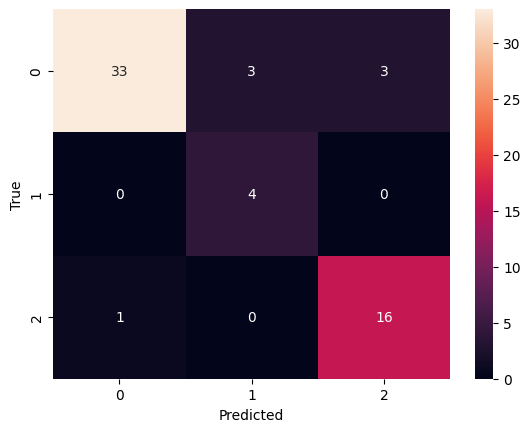

In [178]:
# plot confusion matrix
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Feature Importance

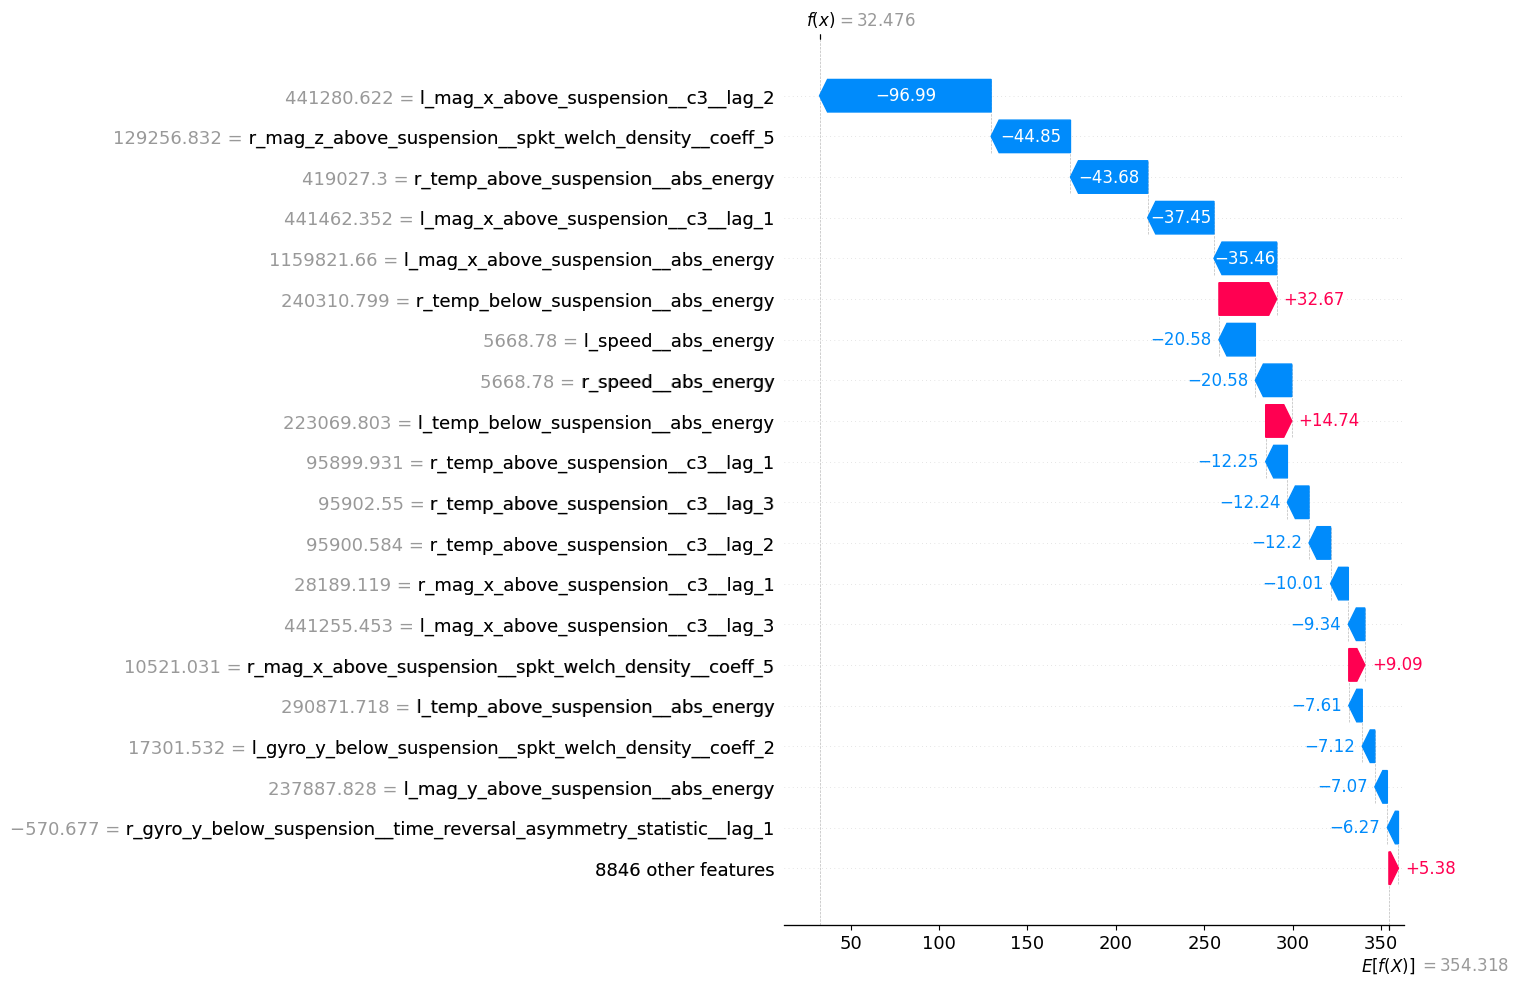

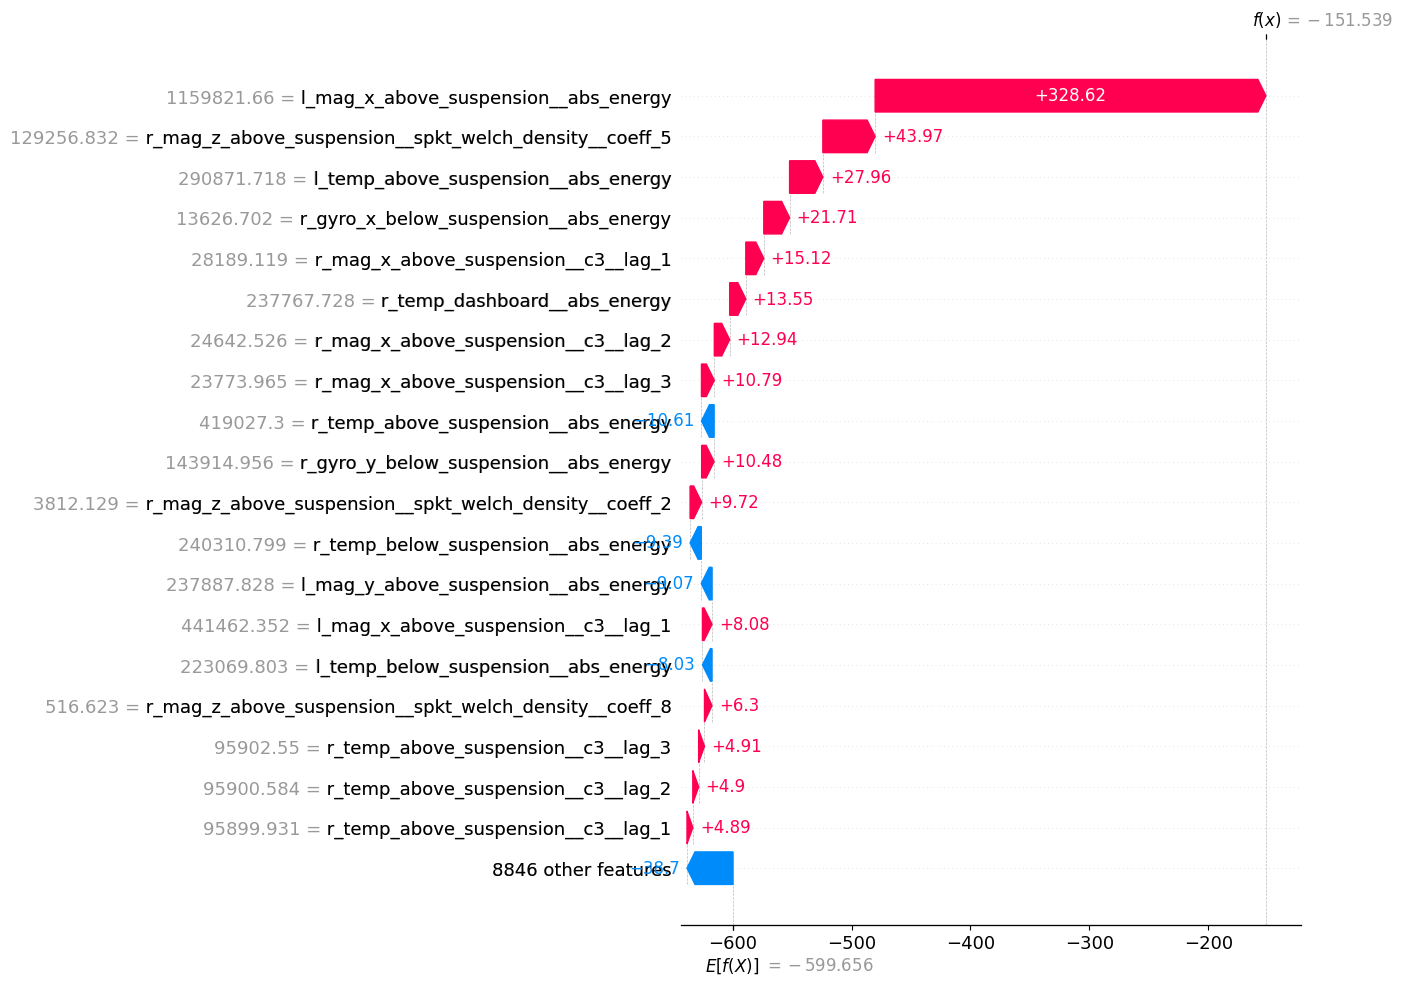

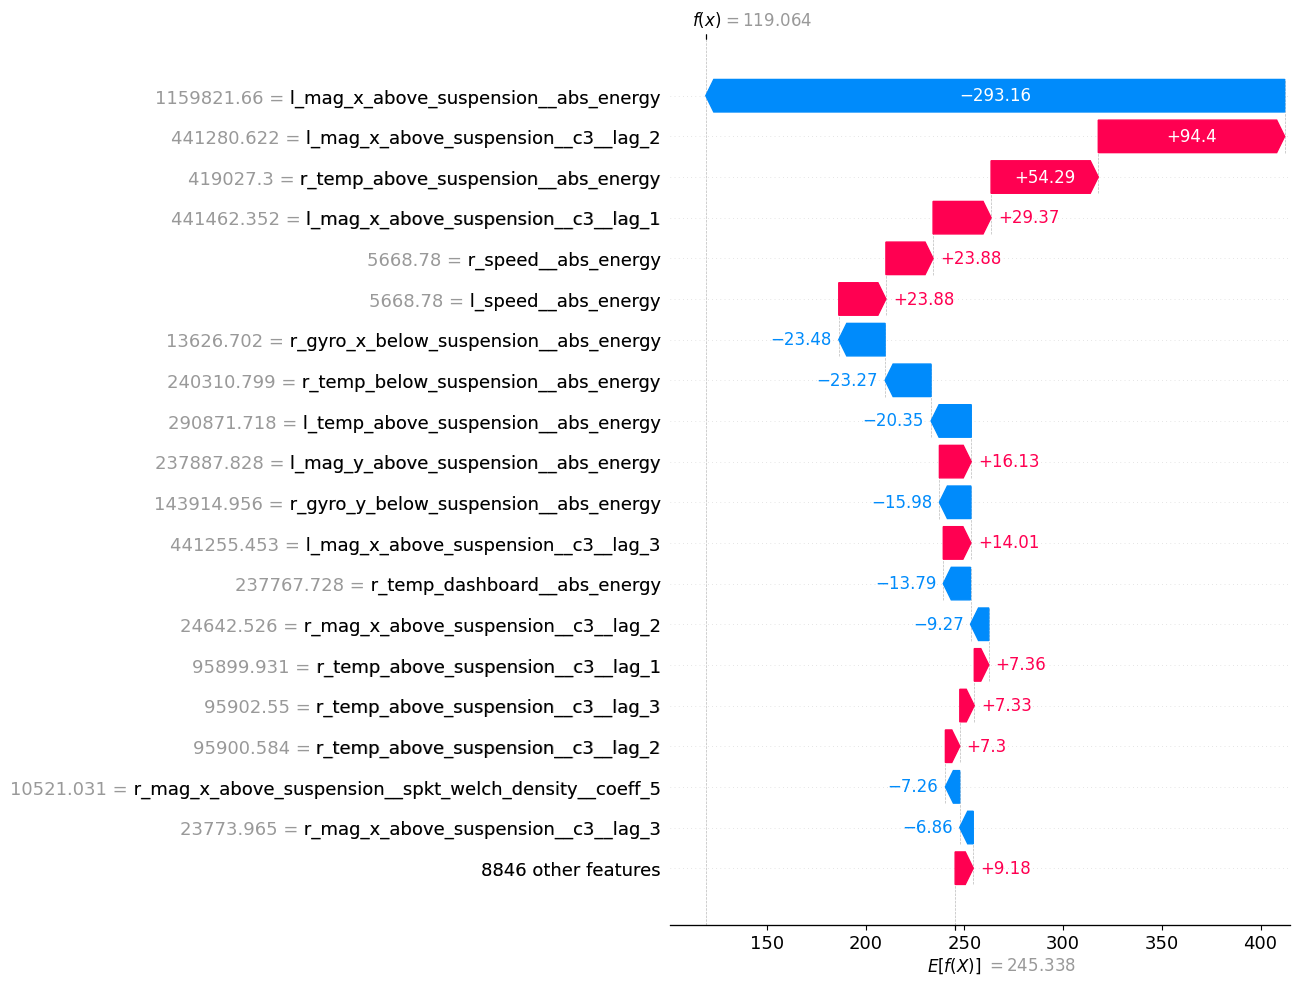

In [162]:
# feature importance
import shap
from sklearn.metrics import confusion_matrix
import seaborn as sns

shap.initjs()

explainer = shap.Explainer(model, X_train.to_numpy(), feature_names=X_train.columns.to_numpy())
shap_values = explainer(X_test)

# waterfall plot for class 0
shap.plots.waterfall(shap_values[0,:,0], max_display=20)

# waterfall plot for class 1
shap.plots.waterfall(shap_values[0,:,1], max_display=20)

# waterfall plot for class 2
shap.plots.waterfall(shap_values[0,:,2], max_display=20)



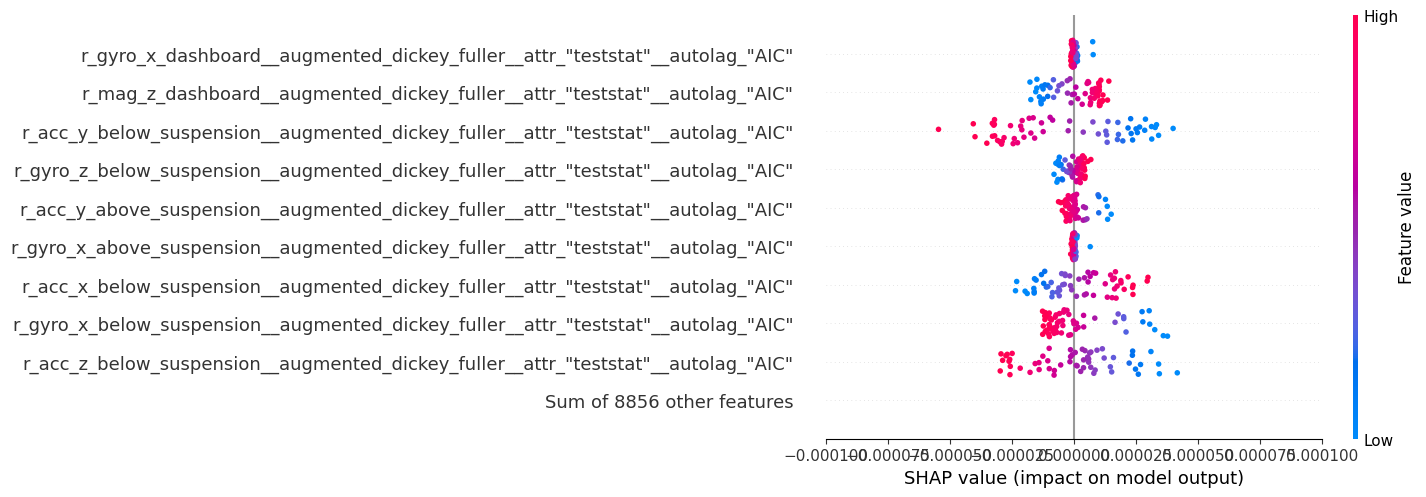

In [155]:
shap_exp = explainer(X_test)
shap.plots.beeswarm(shap_exp[:,:,0], max_display=10, show=False)
# x range
plt.xlim(-0.0001, 0.0001)

plt.show()


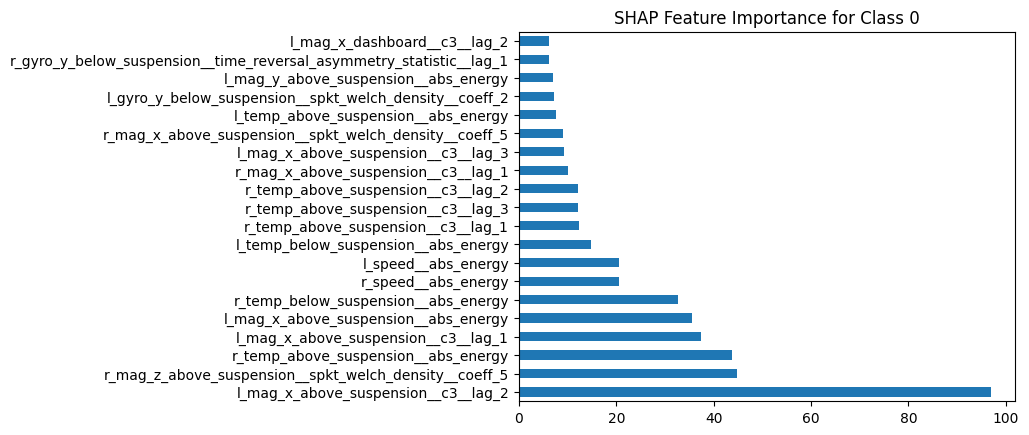

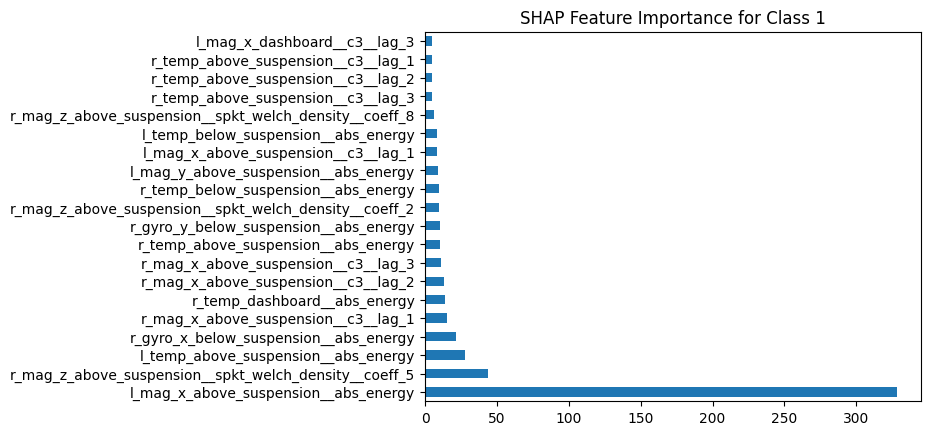

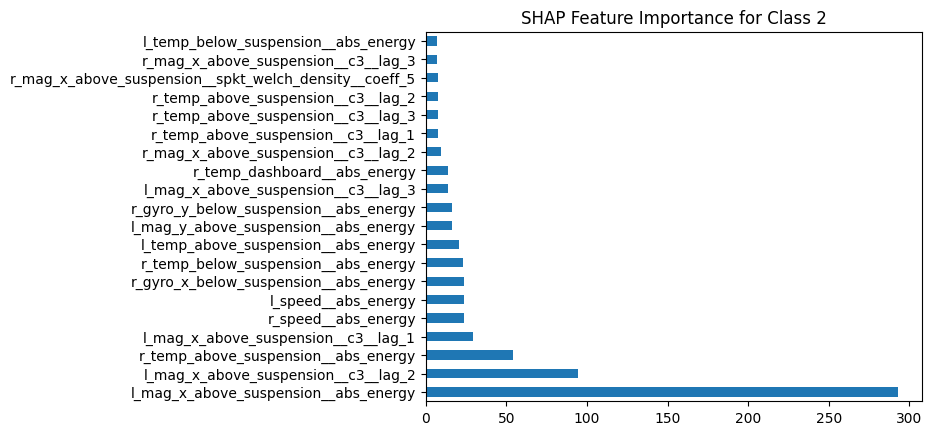

In [163]:
shap_importance0 = pd.Series(shap_values[0,:,0].values, X_train.columns).abs().sort_values(ascending=False)
shap_importance0 = shap_importance0[:20]
shap_importance0.plot(kind="barh")
plt.title("SHAP Feature Importance for Class 0")
plt.show()

shap_importance1 = pd.Series(shap_values[0,:,1].values, X_train.columns).abs().sort_values(ascending=False)
shap_importance1 = shap_importance1[:20]
shap_importance1.plot(kind="barh")
plt.title("SHAP Feature Importance for Class 1")
plt.show()

shap_importance2 = pd.Series(shap_values[0,:,2].values, X_train.columns).abs().sort_values(ascending=False)
shap_importance2 = shap_importance2[:20]
shap_importance2.plot(kind="barh")
plt.title("SHAP Feature Importance for Class 2")
plt.show()



# plot confusion matrix
# cm = confusion_matrix(y_test, y_pred)
# sns.heatmap(cm, annot=True, fmt="d")
# plt.xlabel("Predicted")
# plt.ylabel("Actual")
# plt.show()


In [166]:
# make a union of the shap importance for all classes
shap_importance = shap_importance0.index.union(shap_importance1.index).union(shap_importance2.index)
shap_importance = shap_importance.unique()
shap_importance = shap_importance.tolist()

for feature in shap_importance:
    print(feature)

print('Total number of features:', len(shap_importance))

l_gyro_y_below_suspension__spkt_welch_density__coeff_2
l_mag_x_above_suspension__abs_energy
l_mag_x_above_suspension__c3__lag_1
l_mag_x_above_suspension__c3__lag_2
l_mag_x_above_suspension__c3__lag_3
l_mag_x_dashboard__c3__lag_2
l_mag_x_dashboard__c3__lag_3
l_mag_y_above_suspension__abs_energy
l_speed__abs_energy
l_temp_above_suspension__abs_energy
l_temp_below_suspension__abs_energy
r_gyro_x_below_suspension__abs_energy
r_gyro_y_below_suspension__abs_energy
r_gyro_y_below_suspension__time_reversal_asymmetry_statistic__lag_1
r_mag_x_above_suspension__c3__lag_1
r_mag_x_above_suspension__c3__lag_2
r_mag_x_above_suspension__c3__lag_3
r_mag_x_above_suspension__spkt_welch_density__coeff_5
r_mag_z_above_suspension__spkt_welch_density__coeff_2
r_mag_z_above_suspension__spkt_welch_density__coeff_5
r_mag_z_above_suspension__spkt_welch_density__coeff_8
r_speed__abs_energy
r_temp_above_suspension__abs_energy
r_temp_above_suspension__c3__lag_1
r_temp_above_suspension__c3__lag_2
r_temp_above_suspen

              precision    recall  f1-score   support

           0       0.97      0.85      0.90        39
           1       0.57      1.00      0.73         4
           2       0.84      0.94      0.89        17

    accuracy                           0.88        60
   macro avg       0.79      0.93      0.84        60
weighted avg       0.91      0.88      0.89        60



/home/arabi/.pyenv/versions/3.11.7/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


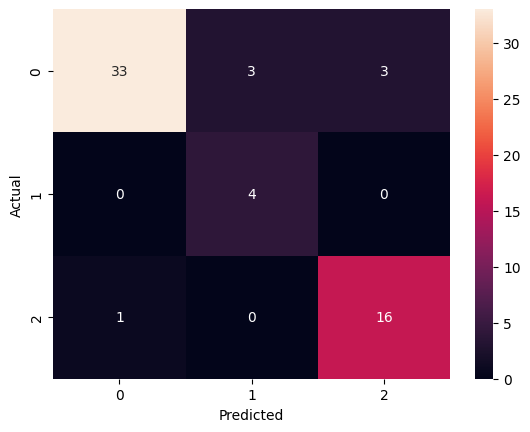

In [167]:
filtered_features = rel_features[shap_importance]

X_train, X_test, y_train, y_test = train_test_split(filtered_features, target, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

# plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# save the filtered features

In [168]:
# save the filtered features colum names
filtered_columns = filtered_features.columns
filtered_columns = filtered_columns.to_numpy()
np.save("filtered_columns.npy", filtered_columns)

# Whole dataset

In [1]:
import datasetReader
totalData = datasetReader.readDf()

Len of current data:  296
Last id:  296
Len of current data:  204
Last id:  500
Len of current data:  40
Last id:  540
Len of current data:  284
Last id:  824
Len of current data:  195
Last id:  1019
Len of current data:  39
Last id:  1058
Len of current data:  275
Last id:  1333
Len of current data:  189
Last id:  1522
Len of current data:  40
Last id:  1562


In [2]:
totalData.to_csv("totalData.csv", index=False)

In [5]:
data = pd.read_csv("totalData.csv")
print(data.shape)

(312400, 59)


# Feature extraction

In [6]:
feature_names = np.load("filtered_columns.npy", allow_pickle=True)
print(feature_names)
print("Total number of features:", len(feature_names))

['l_gyro_y_below_suspension__spkt_welch_density__coeff_2'
 'l_mag_x_above_suspension__abs_energy'
 'l_mag_x_above_suspension__c3__lag_1'
 'l_mag_x_above_suspension__c3__lag_2'
 'l_mag_x_above_suspension__c3__lag_3' 'l_mag_x_dashboard__c3__lag_2'
 'l_mag_x_dashboard__c3__lag_3' 'l_mag_y_above_suspension__abs_energy'
 'l_speed__abs_energy' 'l_temp_above_suspension__abs_energy'
 'l_temp_below_suspension__abs_energy'
 'r_gyro_x_below_suspension__abs_energy'
 'r_gyro_y_below_suspension__abs_energy'
 'r_gyro_y_below_suspension__time_reversal_asymmetry_statistic__lag_1'
 'r_mag_x_above_suspension__c3__lag_1'
 'r_mag_x_above_suspension__c3__lag_2'
 'r_mag_x_above_suspension__c3__lag_3'
 'r_mag_x_above_suspension__spkt_welch_density__coeff_5'
 'r_mag_z_above_suspension__spkt_welch_density__coeff_2'
 'r_mag_z_above_suspension__spkt_welch_density__coeff_5'
 'r_mag_z_above_suspension__spkt_welch_density__coeff_8'
 'r_speed__abs_energy' 'r_temp_above_suspension__abs_energy'
 'r_temp_above_suspensio

# Create the reduced dataset with specific columns

In [10]:

reduced_columns = ["id", "time", "class"]
for feature in feature_names:
    cname = feature.split("__")[0]
    if cname not in reduced_columns:
        reduced_columns.append(cname)

reduced_data = data[reduced_columns]

reduced_data.to_csv("reducedData.csv", index=False)

# Read reduced dataset

In [11]:
dataset = pd.read_csv("reducedData.csv")

# Extract features

In [12]:
from tsfresh import extract_features
# impute
from tsfresh.utilities.dataframe_functions import impute
dataset_features = extract_features(dataset, column_id="id", column_sort="time", n_jobs=12, impute_function=impute)

Feature Extraction: 100%|██████████| 60/60 [01:59<00:00,  2.00s/it]


# Select relevant features

In [13]:
# select the relevant features
reduced_features = dataset_features[feature_names]
targets = reduced_data[["id", "class"]].drop_duplicates().set_index("id")["class"].to_numpy()
print(targets)
print(reduced_features.shape)

[0 0 0 ... 2 2 2]
(1562, 28)


# Save the feature dataset

In [14]:
# append the class column to the reduced features
reduced_features["class"] = targets
# save the reduced dataset
reduced_features.to_csv("featureDataset.csv", index=False)

C:\Users\arabi\AppData\Local\Temp\ipykernel_22156\768807409.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_features["class"] = targets


# Model test Logistic Regression

              precision    recall  f1-score   support

           0       0.84      0.85      0.85       198
           1       0.67      0.55      0.60        53
           2       0.66      0.74      0.70        62

    accuracy                           0.78       313
   macro avg       0.73      0.71      0.72       313
weighted avg       0.78      0.78      0.78       313



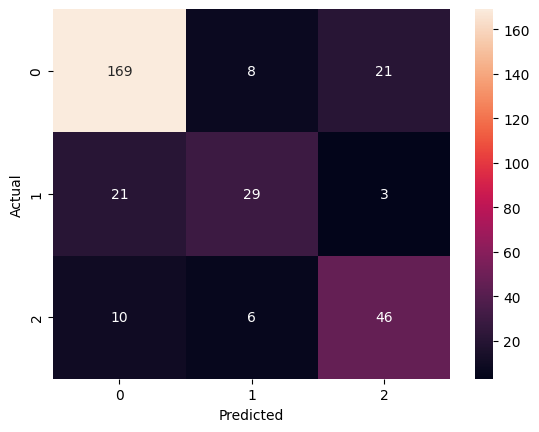

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

featureDataset = pd.read_csv("featureDataset.csv")

X_train, X_test, y_train, y_test = train_test_split(featureDataset.drop(columns="class"), featureDataset["class"], test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

# plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()